**Part 1: Feature Extraction**

In [37]:
import kagglehub
path = kagglehub.dataset_download("adityajn105/flickr30k")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr30k


In [38]:
import os
import pickle
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import pandas as pd


In [39]:
IMAGE_DIR = "/kaggle/input/flickr30k/Images"
CAPTIONS_PATH = "/kaggle/input/flickr30k/captions.txt"


In [40]:
print("Images:", len(os.listdir(IMAGE_DIR)))
pd.read_csv(CAPTIONS_PATH).head()


Images: 31785


,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [41]:
class FlickrImageDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.images = [img for img in os.listdir(img_dir) if img.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        return self.transform(image), img_name


In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])  
resnet = nn.DataParallel(resnet)
resnet = resnet.to(device)
resnet.eval()


DataParallel(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [44]:
dataset = FlickrImageDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

In [45]:
features = {}

with torch.no_grad():
    for imgs, names in tqdm(loader):
        imgs = imgs.to(device)
        feats = resnet(imgs).squeeze()
        for i, name in enumerate(names):
            features[name] = feats[i].cpu().numpy()


100%|██████████| 249/249 [01:54<00:00,  2.18it/s]


In [46]:
with open("flickr30k_features.pkl", "wb") as f:
    pickle.dump(features, f)

print("Features saved successfully")


Features saved successfully


**Part 2: Captions preprocessing and vocabulary**

In [47]:
import re
from collections import Counter

In [48]:
df = pd.read_csv(CAPTIONS_PATH)
df.head()


,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [49]:
def clean_caption(caption):
    if not isinstance(caption, str):
        return ""
    caption = caption.lower()
    caption = re.sub(r"[^a-z\s]", "", caption)
    caption = caption.strip()
    return caption


In [50]:
df["clean_caption"] = df["caption"].apply(clean_caption)
df.head()


,image,caption,clean_caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...,two young guys with shaggy hair look at their ...
1,1000092795.jpg,"Two young , White males are outside near many...",two young white males are outside near many b...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,two men in green shirts are standing in a yard
3,1000092795.jpg,A man in a blue shirt standing in a garden .,a man in a blue shirt standing in a garden
4,1000092795.jpg,Two friends enjoy time spent together .,two friends enjoy time spent together


In [51]:
df = df[df["clean_caption"] != ""].reset_index(drop=True)


In [52]:
df["clean_caption"] = df["clean_caption"].apply(
    lambda x: "<start> " + x + " <end>"
)

In [53]:
from collections import Counter

word_counts = Counter()

for cap in df["clean_caption"]:
    word_counts.update(cap.split())


In [54]:
MIN_FREQ = 5
vocab = [w for w, c in word_counts.items() if c >= MIN_FREQ]
vocab = ["<pad>", "<unk>"] + vocab


In [55]:
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Vocab size:", len(word2idx))


Vocab size: 7689


In [56]:
def caption_to_indices(caption, word2idx):
    return [
        word2idx.get(word, word2idx["<unk>"])
        for word in caption.split()
    ]


In [57]:
df["caption_idx"] = df["clean_caption"].apply(
    lambda x: caption_to_indices(x, word2idx)
)

df.head()


,image,caption,clean_caption,caption_idx
0,1000092795.jpg,Two young guys with shaggy hair look at their...,<start> two young guys with shaggy hair look a...,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,1000092795.jpg,"Two young , White males are outside near many...",<start> two young white males are outside nea...,"[2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 19]"
2,1000092795.jpg,Two men in green shirts are standing in a yard .,<start> two men in green shirts are standing i...,"[2, 3, 27, 16, 28, 29, 22, 30, 16, 31, 18, 19]"
3,1000092795.jpg,A man in a blue shirt standing in a garden .,<start> a man in a blue shirt standing in a ga...,"[2, 31, 32, 16, 31, 33, 34, 30, 16, 31, 35, 19]"
4,1000092795.jpg,Two friends enjoy time spent together .,<start> two friends enjoy time spent together ...,"[2, 3, 36, 37, 38, 1, 39, 19]"


In [58]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(word2idx, f)

with open("idx2word.pkl", "wb") as f:
    pickle.dump(idx2word, f)

df.to_pickle("captions_processed.pkl")

**PART 3: ENCODER–DECODER MODEL**

In [59]:
import pickle

with open("flickr30k_features.pkl", "rb") as f:
    image_features = pickle.load(f)

df = pd.read_pickle("captions_processed.pkl")

with open("vocab.pkl", "rb") as f:
    word2idx = pickle.load(f)

with open("idx2word.pkl", "rb") as f:
    idx2word = pickle.load(f)

vocab_size = len(word2idx)
pad_idx = word2idx["<pad>"]

print("Images:", len(image_features))
print("Captions:", len(df))


Images: 31783
Captions: 158914


In [60]:
class CaptionDataset(Dataset):
    def __init__(self, df, features, pad_idx, max_len=30):
        self.df = df
        self.features = features
        self.pad_idx = pad_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["image"]
        caption = row["caption_idx"]

        feature = self.features[img_name]

        if len(caption) < self.max_len:
            caption = caption + [self.pad_idx] * (self.max_len - len(caption))
        else:
            caption = caption[:self.max_len]

        caption = torch.tensor(caption)

        return torch.tensor(feature, dtype=torch.float32), caption


In [61]:
dataset = CaptionDataset(df, image_features, pad_idx)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [62]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.fc = nn.Linear(2048, embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.fc(x))

In [63]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        features = features.unsqueeze(1)
        inputs = torch.cat((features, embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.fc(hiddens)
        return outputs


In [64]:
embed_size = 256
hidden_size = 512

encoder = Encoder(embed_size)
decoder = Decoder(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = encoder.to(device)
decoder = decoder.to(device)


In [65]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)


**Part 4: Model Training, Caption Generation and Evaluation**

In [66]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = CaptionDataset(train_df, image_features, pad_idx)
val_dataset   = CaptionDataset(val_df, image_features, pad_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [76]:
num_epochs = 10
train_losses = []
val_losses = []

# Early stopping setup
best_val_loss = float("inf")
patience = 3
counter = 0

for epoch in range(num_epochs):

    # ===== TRAINING =====
    encoder.train()
    decoder.train()
    total_train_loss = 0

    for features, captions in train_loader:
        features, captions = features.to(device), captions.to(device)

        inputs = captions[:, :-1]
        targets = captions[:, 1:]

        outputs = decoder(encoder(features), inputs)
        outputs = outputs[:, 1:, :]

        loss = criterion(
            outputs.reshape(-1, vocab_size),
            targets.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===== VALIDATION =====
    encoder.eval()
    decoder.eval()
    total_val_loss = 0

    with torch.no_grad():
        for features, captions in val_loader:
            features, captions = features.to(device), captions.to(device)

            inputs = captions[:, :-1]
            targets = captions[:, 1:]

            outputs = decoder(encoder(features), inputs)
            outputs = outputs[:, 1:, :]

            loss = criterion(
                outputs.reshape(-1, vocab_size),
                targets.reshape(-1)
            )

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ===== EARLY STOPPING =====
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(decoder.state_dict(), "best_decoder.pth")
        print("Best model saved")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break


# ===== LOAD BEST MODEL AFTER TRAINING =====
decoder.load_state_dict(torch.load("best_decoder.pth"))
print("Best model loaded")


Epoch [1/10] Train Loss: 1.8381 | Val Loss: 3.0783
Best model saved
Epoch [2/10] Train Loss: 1.7732 | Val Loss: 3.1285
Epoch [3/10] Train Loss: 1.7174 | Val Loss: 3.1843
Epoch [4/10] Train Loss: 1.6661 | Val Loss: 3.2291
Early stopping triggered
Best model loaded


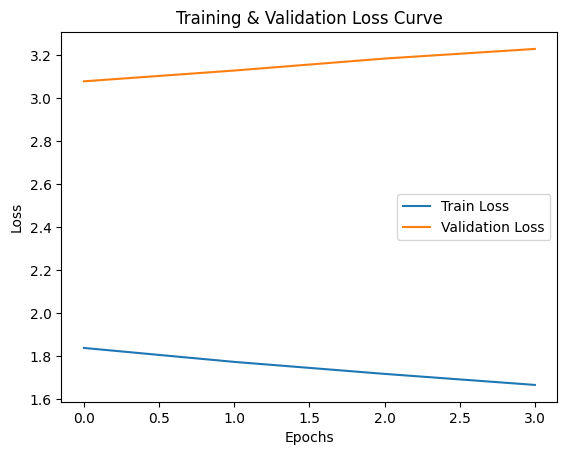

In [77]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.show()


In [78]:
def greedy_caption(feature, encoder, decoder, max_len=20):
    encoder.eval()
    decoder.eval()

    feature = torch.tensor(feature).unsqueeze(0).to(device)
    feature = encoder(feature)

    caption = [word2idx["<start>"]]
    caption = torch.tensor(caption).unsqueeze(0).to(device)

    result = []

    for _ in range(max_len):
        outputs = decoder(feature, caption)
        next_word = outputs.argmax(-1)[:, -1].item()

        if idx2word[next_word] == "<end>":
            break

        result.append(idx2word[next_word])
        caption = torch.cat([caption, torch.tensor([[next_word]]).to(device)], dim=1)

    return " ".join(result)


In [79]:
def beam_search_caption(image_feature, encoder, decoder, beam_size=5, max_len=20):
    encoder.eval()
    decoder.eval()

    device = next(decoder.parameters()).device

    feature = torch.tensor(image_feature).unsqueeze(0).to(device)
    feature = encoder(feature)

    sequences = [([word2idx["<start>"]], 0.0)]

    for _ in range(max_len):
        all_candidates = []

        for seq, score in sequences:
            if seq[-1] == word2idx["<end>"]:
                all_candidates.append((seq, score))
                continue

            input_seq = torch.tensor(seq).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = decoder(feature, input_seq)
                probs = torch.softmax(outputs[0, -1], dim=0)

            top_probs, top_idx = probs.topk(beam_size)

            for i in range(beam_size):
                candidate = (
                    seq + [top_idx[i].item()],
                    score - torch.log(top_probs[i]).item()
                )
                all_candidates.append(candidate)

        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_size]

    best_seq = sequences[0][0]

    caption = []
    for idx in best_seq:
        word = idx2word[idx]
        if word in ["<start>", "<end>", "<pad>"]:
            continue
        caption.append(word)

    return " ".join(caption)


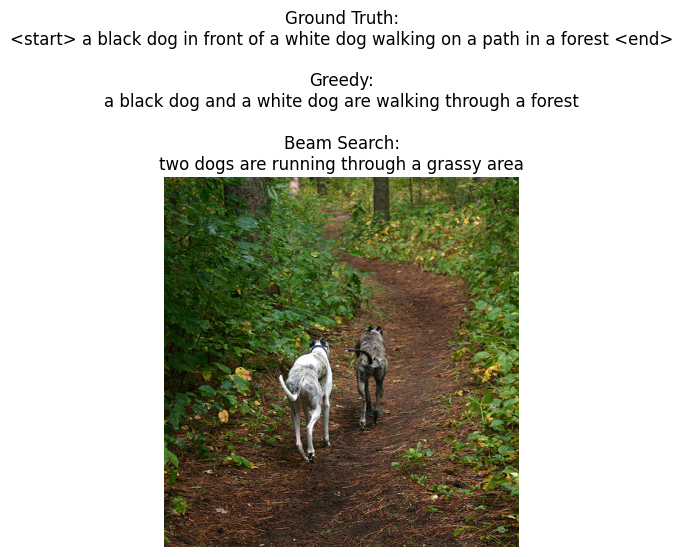

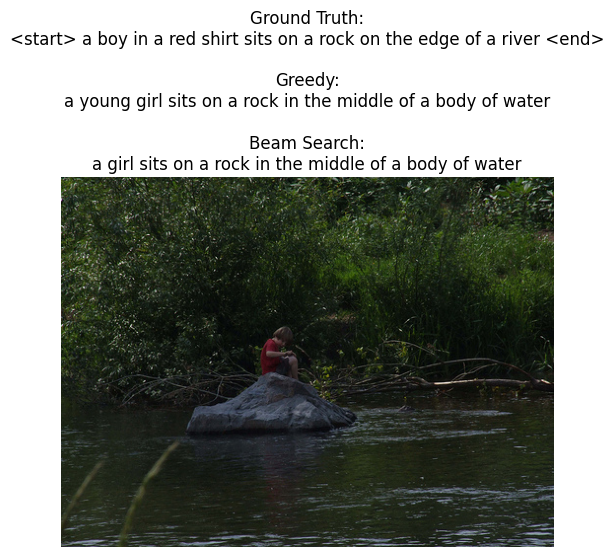

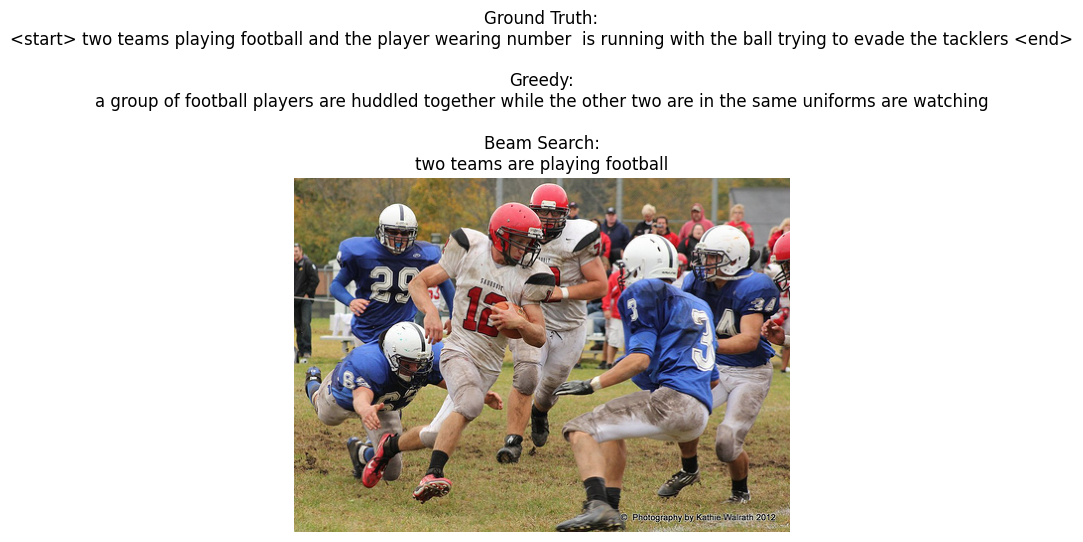

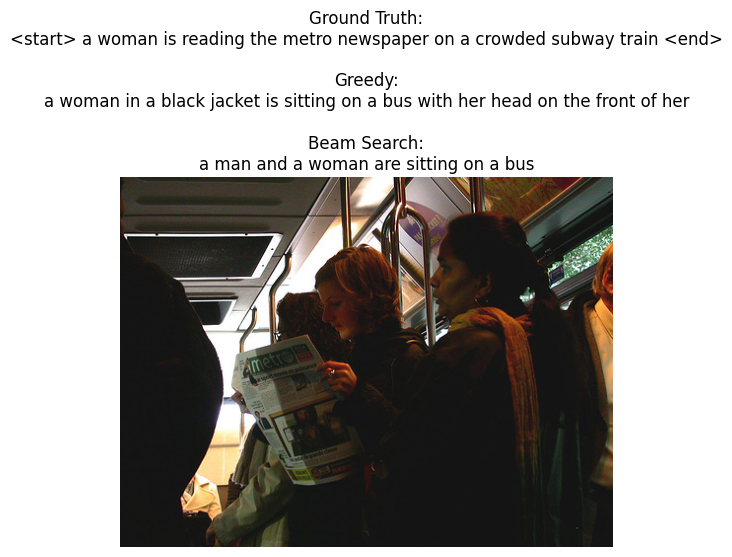

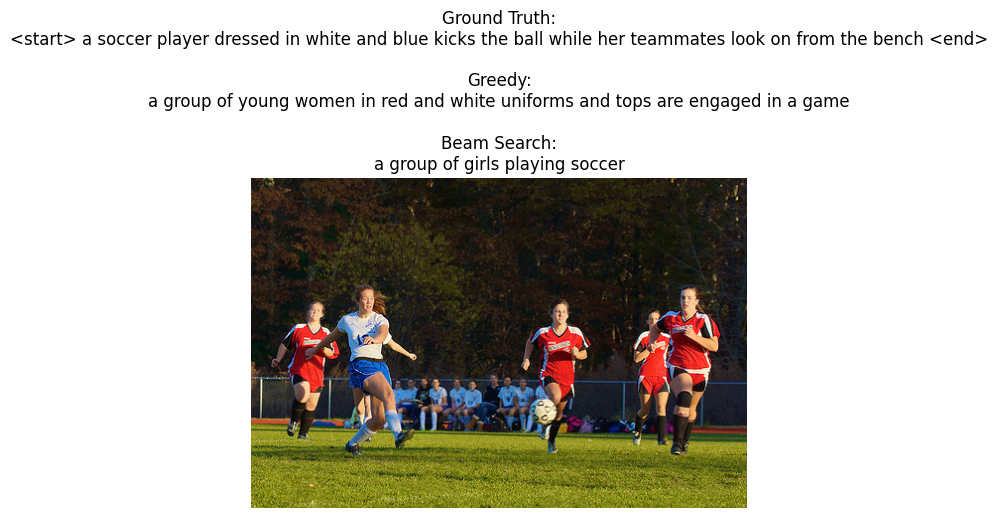

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

In [89]:
import random
import matplotlib.pyplot as plt
from PIL import Image

sample_images = random.sample(list(image_features.keys()), 5)

for img_name in sample_images:
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)

    greedy_pred = greedy_caption(image_features[img_name], encoder, decoder)
    beam_pred   = beam_search_caption(image_features[img_name], encoder, decoder, beam_size=5)

    gt = df[df["image"] == img_name]["clean_caption"].values[0]

    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Ground Truth:\n{gt}\n\n"
        f"Greedy:\n{greedy_pred}\n\n"
        f"Beam Search:\n{beam_pred}"
    )
    plt.show()


In [81]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

references = []
hypotheses = []

smoothie = SmoothingFunction().method4

for i in range(200):
    row = df.iloc[i]

    ref = row["clean_caption"].split()

    # prediction using BEAM SEARCH
    pred = beam_search_caption(
        image_features[row["image"]],
        encoder,
        decoder,
        beam_size=5
    ).split()

    references.append([ref])
    hypotheses.append(pred)

bleu4 = corpus_bleu(
    references,
    hypotheses,
    weights=(0.25, 0.25, 0.25, 0.25),
    smoothing_function=smoothie
)

print("BLEU-4 Score:", bleu4)


BLEU-4 Score: 0.08565460870247422


In [83]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for i in range(200):
    row = df.iloc[i]

true_tokens = row["clean_caption"].split()
true_tokens = [t for t in true_tokens if t not in ["<start>", "<end>", "<pad>"]]

pred_tokens = beam_search_caption(
    image_features[row["image"]],
    encoder,
    decoder,
    beam_size=5
).split()

pred_tokens = [t for t in pred_tokens if t not in ["<start>", "<end>", "<pad>"]]

min_len = min(len(true_tokens), len(pred_tokens))

y_true.extend(true_tokens[:min_len])
y_pred.extend(pred_tokens[:min_len])


precision = precision_score(y_true, y_pred, average="micro", zero_division=0)
recall    = recall_score(y_true, y_pred, average="micro", zero_division=0)
f1        = f1_score(y_true, y_pred, average="micro", zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.0
Recall: 0.0
F1-score: 0.0


In [3]:
import gradio as gr

def caption_image(img):
    img = img.resize((224,224))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    ])

    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = resnet(img).squeeze().cpu().numpy()

    return beam_search_caption(feat, encoder, decoder, beam_size=5)

gr.Interface(
    fn=caption_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Neural Storyteller – Image Captioning"
).launch()


* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://bbba548c14e24d0511.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
